In [1]:
import sys
sys.path.insert(0, '../src/')

import pickle
import warnings
warnings.filterwarnings('ignore')
import time


import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sp
from sklearn.metrics import roc_auc_score, average_precision_score


#from netgan.netgan import *
#from netgan import utils

from net.utils import *
from net import utils_netgan as utils
import net.net as net

In [41]:
def grid_train(Model, train_graph, val_ones, val_zeros, Hs, EOs, mixing_coeff, 
               loss_fn, test_every=50, max_steps=2000):
    """Trains models with specified bottlenecks until specified edge overlaps are achieved and returns their
       graph statistics.
    
    Parameters
    ----------
    Model: net.Net class
               The model class used for training.
    train_graph: sparse matrix
               The train graph.
    val_ones: array
               Validation edges in train graph.
    val_zeros: array
               Validation non-edges in train graph.               
    Hs: list
               Bottlenecks, for which the model is trained.
    EOs: list
               Edge overlaps, for which the model is trained.
    mixing_coeff: float in [0,1]
               Controls contributions of stationary distribution and uniform distribution. 0 is uniform,
               1 is stationary.
    loss_fn: function
               Loss function for the model.
    test_every: integer
               Controls how often the edge overlap for stopping is tested during training.
    max_steps: integer
               Maximum number of training steps allowed to achieve the next edge overlap, starting from the
               model that achieves previous edge overlap.

    Returns
    -------
    dict_of_dicts_of_statistics: dictionary of dictionaries
                   Dictionary, for which value at key [i, j] is dictionary of graph statistics of the 
                   sampled graph with bottleneck Hs[i] and edge overlap EOs[j].

    """
    
    dict_of_dicts_of_statistics = {}
    E = train_graph.sum()
    actual_labels_val = np.append(np.ones(len(val_ones)), np.zeros(len(val_zeros)))
    
    counter = 0
    total = len(Hs) * len(EOs)
    for i, H in enumerate(Hs):
        # Define model with H 
        netmodel = Model(N=train_graph.shape[0],
                         H=H,
                         affine=False,
                         loss_fn=loss_fn,
                         stoppers=[net.OverlapStopper(train_graph=train_graph, 
                                                      mixing_coeff=mixing_coeff,
                                                      test_every=test_every)])
        train_time = 0
        for j, EO in enumerate(EOs):
            counter += 1
            print('Start training with H={H} and EO={EO} ({counter}/{total})'.format(H=H, EO=EO,
                                                                                     counter=counter,
                                                                                     total=total))
            start_time = time.time()

            # Train model until EO is reached, or a maximum of max_steps steps
            netmodel.train(generator=net_walker(walker),
                           steps=max_steps,
                           optimizer_fn=torch.optim.Adam,
                           optimizer_args={'lr': 0.01},
                           EO_criterion=EO)
            
            # Build graph
            transition_matrix = netmodel(torch.arange(start=0,end=_N, dtype=int))

            scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                                 symmetric=True,
                                                                 mixing_coeff=mixing_coeff)
            scores_matrix = sp.csr_matrix(scores_matrix)

            sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
            
            end_time = time.time()
            train_time += end_time - start_time
            # Compute graph statistics
            
            statistics = utils.compute_graph_statistics(sampled_graph)
            statistics['overlap'] = utils.edge_overlap(train_graph.toarray(), sampled_graph)/E
            edge_scores = np.append(scores_matrix[tuple(val_ones.T)].A1, 
                                    scores_matrix[tuple(val_zeros.T)].A1)
            statistics['val_performance'] = (roc_auc_score(actual_labels_val, edge_scores),
                                             average_precision_score(actual_labels_val, edge_scores))
            statistics['time'] = train_time
            
            # Test if EO is achieved
            if statistics['overlap']>EO:
                dict_of_dicts_of_statistics[i, j] = statistics
            else:
                counter += len(EOs) - j - 1
                print("Skipped remaining {} EOs".format(len(EOs) - j - 1))
                break
            
    return dict_of_dicts_of_statistics

def make_H_EO_grid_heatplot(dict_of_dicts_of_statistics, Hs, EOs, keys, show_every=[1, 1]):
    """X.
    
    Parameters
    ----------
    X: X
        X       

    Returns
    -------
    X: X
        X

    """    
    n_rows, n_cols = get_plot_grid_size(len(keys))
    plt.rcParams.update({'font.size': 15})
    f, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))
    axs = np.array(axs).reshape(n_rows, n_cols)
    plt.tight_layout(pad=3)
    for row in range(n_rows):
        for col in range(n_cols):
            i = row * n_cols + col
            if i < len(keys):
                key = keys[row * n_cols + col]
                vals = np.full((len(Hs), len(EOs)), np.nan)
                for index in np.ndindex(len(Hs), len(EOs)):
                    if index in dict_of_dicts_of_statistics.keys():
                        vals[index] = min(dict_of_dicts_of_statistics[index][key], 150)
                axs[row, col].set_title(key)
                im = axs[row, col].imshow(vals.T[::-1]) # Make sure matrix is presented with right orientation
                axs[row, col].figure.colorbar(im, ax=axs[row, col])
                
                axs[row, col].set_xticks(np.arange(len(Hs)))
                axs[row, col].set_yticks(np.arange(len(EOs)))
                axs[row, col].set_xticklabels(Hs)
                axs[row, col].set_yticklabels(EOs[::-1])
                axs[row, col].set_xlabel('Bottleneck H')
                axs[row, col].set_ylabel('Edge overlap EO')   
                for i, label in enumerate(axs[row, col].xaxis.get_ticklabels()):
                    if i % show_every[0] != 0:
                        label.set_visible(False)
                for i, label in enumerate(axs[row, col].yaxis.get_ticklabels()):
                    if i % show_every[1] != 0:
                        label.set_visible(False)                
            else:
                axs[row, col].axis('off')
    plt.savefig('../fig/hyperparameter_grid.pdf', format='pdf')
    return

## Test dependency of graph parameters on bottleneck H and edge overlap EO 

In [3]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

Selecting 1 largest connected components


In [4]:
rw_len = 16
batch_size = 128
mixing_coeff = 1
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

In [5]:
Hs = np.arange(1,101)
EOs = np.arange(0.05, 1, 0.05)

# Hs = [20]
# EOs = [0.3, 0.4]

dict_of_dicts_of_statistics = grid_train(Model=net.Net, train_graph=train_graph,
                                val_ones=val_ones, val_zeros=val_zeros,
                                Hs=Hs, EOs=EOs,
                                mixing_coeff=1,
                                loss_fn=torch.nn.functional.cross_entropy,
                                test_every=25,
                                max_steps=1500) 

Start training with H=1 and EO=0.05 (1/1900)
Step: 24, Loss: 7.93276, Edge-Overlap: 0.002
Step: 49, Loss: 7.90957, Edge-Overlap: 0.001
Step: 74, Loss: 7.85925, Edge-Overlap: 0.003
Step: 99, Loss: 7.80088, Edge-Overlap: 0.002
Step: 124, Loss: 7.68963, Edge-Overlap: 0.002
Step: 149, Loss: 7.61492, Edge-Overlap: 0.004
Step: 174, Loss: 7.54717, Edge-Overlap: 0.005
Step: 199, Loss: 7.48825, Edge-Overlap: 0.005
Step: 224, Loss: 7.45010, Edge-Overlap: 0.007
Step: 249, Loss: 7.31823, Edge-Overlap: 0.009
Step: 274, Loss: 7.28334, Edge-Overlap: 0.013
Step: 299, Loss: 7.26326, Edge-Overlap: 0.013
Step: 324, Loss: 7.16835, Edge-Overlap: 0.014
Step: 349, Loss: 7.17537, Edge-Overlap: 0.016
Step: 374, Loss: 7.12545, Edge-Overlap: 0.015
Step: 399, Loss: 7.10704, Edge-Overlap: 0.018
Step: 424, Loss: 7.14678, Edge-Overlap: 0.022
Step: 449, Loss: 7.14100, Edge-Overlap: 0.018
Step: 474, Loss: 7.07623, Edge-Overlap: 0.016
Step: 499, Loss: 7.10600, Edge-Overlap: 0.019
Step: 524, Loss: 7.00607, Edge-Overlap:

Step: 949, Loss: 4.73332, Edge-Overlap: 0.123
Step: 974, Loss: 4.73491, Edge-Overlap: 0.134
Step: 999, Loss: 4.71281, Edge-Overlap: 0.127
Step: 1024, Loss: 4.70009, Edge-Overlap: 0.130
Step: 1049, Loss: 4.60816, Edge-Overlap: 0.133
Step: 1074, Loss: 4.63429, Edge-Overlap: 0.137
Step: 1099, Loss: 4.53097, Edge-Overlap: 0.138
Step: 1124, Loss: 4.66930, Edge-Overlap: 0.140
Step: 1149, Loss: 4.60457, Edge-Overlap: 0.142
Step: 1174, Loss: 4.60889, Edge-Overlap: 0.154
Skipped remaining 16 EOs
Start training with H=5 and EO=0.05 (77/1900)
Step: 24, Loss: 7.89995, Edge-Overlap: 0.001
Step: 49, Loss: 7.77165, Edge-Overlap: 0.001
Step: 74, Loss: 7.48419, Edge-Overlap: 0.003
Step: 99, Loss: 7.08964, Edge-Overlap: 0.007
Step: 124, Loss: 6.65711, Edge-Overlap: 0.017
Step: 149, Loss: 6.31717, Edge-Overlap: 0.040
Step: 174, Loss: 6.07584, Edge-Overlap: 0.053
Start training with H=5 and EO=0.1 (78/1900)
Step: 174, Loss: 6.06990, Edge-Overlap: 0.053
Step: 199, Loss: 5.95868, Edge-Overlap: 0.068
Step: 2

Step: 1499, Loss: 3.17797, Edge-Overlap: 0.419
Step: 1524, Loss: 3.05848, Edge-Overlap: 0.415
Step: 1549, Loss: 3.10293, Edge-Overlap: 0.425
Step: 1574, Loss: 3.24771, Edge-Overlap: 0.430
Step: 1599, Loss: 2.95514, Edge-Overlap: 0.434
Step: 1624, Loss: 3.00812, Edge-Overlap: 0.438
Step: 1649, Loss: 2.91297, Edge-Overlap: 0.436
Step: 1674, Loss: 3.11336, Edge-Overlap: 0.437
Step: 1699, Loss: 3.07954, Edge-Overlap: 0.446
Step: 1724, Loss: 2.95087, Edge-Overlap: 0.452
Start training with H=7 and EO=0.5 (124/1900)
Step: 1724, Loss: 3.08364, Edge-Overlap: 0.455
Step: 1749, Loss: 3.01577, Edge-Overlap: 0.446
Step: 1774, Loss: 3.13894, Edge-Overlap: 0.449
Step: 1799, Loss: 3.09998, Edge-Overlap: 0.446
Step: 1824, Loss: 3.04192, Edge-Overlap: 0.455
Step: 1849, Loss: 3.01083, Edge-Overlap: 0.456
Step: 1874, Loss: 3.08716, Edge-Overlap: 0.456
Step: 1899, Loss: 2.98845, Edge-Overlap: 0.462
Step: 1924, Loss: 3.01516, Edge-Overlap: 0.465
Step: 1949, Loss: 3.06766, Edge-Overlap: 0.461
Step: 1974, Lo

Step: 424, Loss: 3.31065, Edge-Overlap: 0.384
Step: 449, Loss: 3.19537, Edge-Overlap: 0.409
Start training with H=12 and EO=0.45 (218/1900)
Step: 449, Loss: 3.12379, Edge-Overlap: 0.402
Step: 474, Loss: 3.11623, Edge-Overlap: 0.416
Step: 499, Loss: 3.00127, Edge-Overlap: 0.436
Step: 524, Loss: 2.81583, Edge-Overlap: 0.441
Step: 549, Loss: 3.01957, Edge-Overlap: 0.471
Start training with H=12 and EO=0.5 (219/1900)
Step: 549, Loss: 2.78032, Edge-Overlap: 0.469
Step: 574, Loss: 2.91791, Edge-Overlap: 0.484
Step: 599, Loss: 2.73428, Edge-Overlap: 0.490
Step: 624, Loss: 2.82051, Edge-Overlap: 0.498
Step: 649, Loss: 2.64212, Edge-Overlap: 0.524
Start training with H=12 and EO=0.55 (220/1900)
Step: 649, Loss: 2.68095, Edge-Overlap: 0.517
Step: 674, Loss: 2.72468, Edge-Overlap: 0.518
Step: 699, Loss: 2.66956, Edge-Overlap: 0.523
Step: 724, Loss: 2.52222, Edge-Overlap: 0.542
Step: 749, Loss: 2.60941, Edge-Overlap: 0.557
Start training with H=12 and EO=0.6000000000000001 (221/1900)
Step: 749, Lo

Step: 499, Loss: 2.48113, Edge-Overlap: 0.594
Step: 524, Loss: 2.49200, Edge-Overlap: 0.615
Start training with H=17 and EO=0.6500000000000001 (317/1900)
Step: 524, Loss: 2.45063, Edge-Overlap: 0.616
Step: 549, Loss: 2.50695, Edge-Overlap: 0.624
Step: 574, Loss: 2.41266, Edge-Overlap: 0.638
Step: 599, Loss: 2.39271, Edge-Overlap: 0.650
Start training with H=17 and EO=0.7000000000000001 (318/1900)
Step: 599, Loss: 2.37809, Edge-Overlap: 0.645
Step: 624, Loss: 2.39004, Edge-Overlap: 0.661
Step: 649, Loss: 2.34979, Edge-Overlap: 0.674
Step: 674, Loss: 2.29761, Edge-Overlap: 0.686
Step: 699, Loss: 2.31071, Edge-Overlap: 0.700
Skipped remaining 5 EOs
Start training with H=18 and EO=0.05 (324/1900)
Step: 24, Loss: 7.79633, Edge-Overlap: 0.001
Step: 49, Loss: 7.34982, Edge-Overlap: 0.003
Step: 74, Loss: 6.37102, Edge-Overlap: 0.017
Step: 99, Loss: 5.37126, Edge-Overlap: 0.096
Start training with H=18 and EO=0.1 (325/1900)
Step: 99, Loss: 5.26170, Edge-Overlap: 0.094
Step: 124, Loss: 4.63080, 

Step: 924, Loss: 2.10344, Edge-Overlap: 0.799
Step: 949, Loss: 2.03639, Edge-Overlap: 0.806
Start training with H=19 and EO=0.8500000000000001 (359/1900)
Step: 949, Loss: 2.16461, Edge-Overlap: 0.799
Step: 974, Loss: 2.05255, Edge-Overlap: 0.797
Step: 999, Loss: 2.14680, Edge-Overlap: 0.803
Step: 1024, Loss: 2.10610, Edge-Overlap: 0.805
Step: 1049, Loss: 2.13788, Edge-Overlap: 0.825
Step: 1074, Loss: 2.08321, Edge-Overlap: 0.819
Step: 1099, Loss: 2.09234, Edge-Overlap: 0.827
Step: 1124, Loss: 2.12063, Edge-Overlap: 0.826
Step: 1149, Loss: 2.03315, Edge-Overlap: 0.830
Step: 1174, Loss: 2.17436, Edge-Overlap: 0.833
Step: 1199, Loss: 2.05340, Edge-Overlap: 0.837
Step: 1224, Loss: 2.09580, Edge-Overlap: 0.839
Step: 1249, Loss: 2.06452, Edge-Overlap: 0.848
Step: 1274, Loss: 2.10924, Edge-Overlap: 0.844
Step: 1299, Loss: 2.03186, Edge-Overlap: 0.849
Step: 1324, Loss: 2.03467, Edge-Overlap: 0.853
Skipped remaining 2 EOs
Start training with H=20 and EO=0.05 (362/1900)
Step: 24, Loss: 7.77676, 

Start training with H=22 and EO=0.7500000000000001 (414/1900)
Step: 499, Loss: 2.27928, Edge-Overlap: 0.705
Step: 524, Loss: 2.17730, Edge-Overlap: 0.709
Step: 549, Loss: 2.22417, Edge-Overlap: 0.725
Step: 574, Loss: 2.21974, Edge-Overlap: 0.748
Step: 599, Loss: 2.23214, Edge-Overlap: 0.762
Start training with H=22 and EO=0.8 (415/1900)
Step: 599, Loss: 2.16863, Edge-Overlap: 0.758
Step: 624, Loss: 2.26803, Edge-Overlap: 0.761
Step: 649, Loss: 2.15055, Edge-Overlap: 0.770
Step: 674, Loss: 2.07859, Edge-Overlap: 0.781
Step: 699, Loss: 2.14429, Edge-Overlap: 0.792
Step: 724, Loss: 1.99585, Edge-Overlap: 0.801
Start training with H=22 and EO=0.8500000000000001 (416/1900)
Step: 724, Loss: 2.14762, Edge-Overlap: 0.802
Step: 749, Loss: 2.14876, Edge-Overlap: 0.788
Step: 774, Loss: 2.06089, Edge-Overlap: 0.805
Step: 799, Loss: 2.05390, Edge-Overlap: 0.804
Step: 824, Loss: 2.06327, Edge-Overlap: 0.811
Step: 849, Loss: 2.04515, Edge-Overlap: 0.821
Step: 874, Loss: 2.11645, Edge-Overlap: 0.830
S

Start training with H=26 and EO=0.1 (477/1900)
Step: 99, Loss: 4.46858, Edge-Overlap: 0.187
Start training with H=26 and EO=0.15000000000000002 (478/1900)
Step: 99, Loss: 4.38763, Edge-Overlap: 0.186
Start training with H=26 and EO=0.2 (479/1900)
Step: 99, Loss: 4.49762, Edge-Overlap: 0.194
Step: 124, Loss: 3.93537, Edge-Overlap: 0.265
Start training with H=26 and EO=0.25 (480/1900)
Step: 124, Loss: 3.92943, Edge-Overlap: 0.275
Start training with H=26 and EO=0.3 (481/1900)
Step: 124, Loss: 3.92890, Edge-Overlap: 0.270
Step: 149, Loss: 3.59774, Edge-Overlap: 0.355
Start training with H=26 and EO=0.35000000000000003 (482/1900)
Step: 149, Loss: 3.49516, Edge-Overlap: 0.340
Step: 174, Loss: 3.22724, Edge-Overlap: 0.413
Start training with H=26 and EO=0.4 (483/1900)
Step: 174, Loss: 3.16849, Edge-Overlap: 0.414
Start training with H=26 and EO=0.45 (484/1900)
Step: 174, Loss: 3.22950, Edge-Overlap: 0.406
Step: 199, Loss: 3.06460, Edge-Overlap: 0.463
Start training with H=26 and EO=0.5 (485/

Step: 2299, Loss: 2.04114, Edge-Overlap: 0.922
Step: 2324, Loss: 1.98952, Edge-Overlap: 0.924
Step: 2349, Loss: 2.02171, Edge-Overlap: 0.928
Step: 2374, Loss: 1.98169, Edge-Overlap: 0.927
Step: 2399, Loss: 2.03657, Edge-Overlap: 0.925
Step: 2424, Loss: 2.02794, Edge-Overlap: 0.929
Step: 2449, Loss: 2.06660, Edge-Overlap: 0.931
Step: 2474, Loss: 2.03386, Edge-Overlap: 0.927
Step: 2499, Loss: 2.00808, Edge-Overlap: 0.932
Step: 2524, Loss: 2.05522, Edge-Overlap: 0.930
Step: 2549, Loss: 1.98780, Edge-Overlap: 0.927
Step: 2574, Loss: 2.01010, Edge-Overlap: 0.928
Step: 2599, Loss: 2.03218, Edge-Overlap: 0.929
Step: 2624, Loss: 1.98936, Edge-Overlap: 0.928
Step: 2649, Loss: 2.03061, Edge-Overlap: 0.935
Step: 2674, Loss: 2.04732, Edge-Overlap: 0.929
Step: 2699, Loss: 1.98182, Edge-Overlap: 0.929
Skipped remaining 0 EOs
Start training with H=28 and EO=0.05 (514/1900)
Step: 24, Loss: 7.71596, Edge-Overlap: 0.002
Step: 49, Loss: 7.04610, Edge-Overlap: 0.005
Step: 74, Loss: 5.64357, Edge-Overlap: 

Step: 2374, Loss: 2.01204, Edge-Overlap: 0.928
Step: 2399, Loss: 2.10614, Edge-Overlap: 0.929
Step: 2424, Loss: 2.13759, Edge-Overlap: 0.932
Step: 2449, Loss: 2.12019, Edge-Overlap: 0.932
Step: 2474, Loss: 1.99787, Edge-Overlap: 0.928
Step: 2499, Loss: 1.99963, Edge-Overlap: 0.932
Step: 2524, Loss: 2.00350, Edge-Overlap: 0.933
Step: 2549, Loss: 2.01771, Edge-Overlap: 0.931
Step: 2574, Loss: 2.05053, Edge-Overlap: 0.934
Step: 2599, Loss: 1.98847, Edge-Overlap: 0.933
Skipped remaining 0 EOs
Start training with H=31 and EO=0.05 (571/1900)
Step: 24, Loss: 7.69869, Edge-Overlap: 0.002
Step: 49, Loss: 6.89529, Edge-Overlap: 0.005
Step: 74, Loss: 5.43777, Edge-Overlap: 0.065
Start training with H=31 and EO=0.1 (572/1900)
Step: 74, Loss: 5.44848, Edge-Overlap: 0.064
Step: 99, Loss: 4.59017, Edge-Overlap: 0.186
Start training with H=31 and EO=0.15000000000000002 (573/1900)
Step: 99, Loss: 4.51482, Edge-Overlap: 0.181
Start training with H=31 and EO=0.2 (574/1900)
Step: 99, Loss: 4.47643, Edge-O

Step: 724, Loss: 2.07115, Edge-Overlap: 0.867
Step: 749, Loss: 2.04468, Edge-Overlap: 0.869
Step: 774, Loss: 2.09693, Edge-Overlap: 0.880
Step: 799, Loss: 2.09410, Edge-Overlap: 0.883
Step: 824, Loss: 2.04429, Edge-Overlap: 0.888
Step: 849, Loss: 2.18296, Edge-Overlap: 0.890
Step: 874, Loss: 2.11550, Edge-Overlap: 0.893
Step: 899, Loss: 2.07859, Edge-Overlap: 0.897
Step: 924, Loss: 2.08666, Edge-Overlap: 0.894
Step: 949, Loss: 1.96826, Edge-Overlap: 0.895
Step: 974, Loss: 2.10863, Edge-Overlap: 0.900
Step: 999, Loss: 2.17051, Edge-Overlap: 0.904
Skipped remaining 1 EOs
Start training with H=34 and EO=0.05 (628/1900)
Step: 24, Loss: 7.65871, Edge-Overlap: 0.003
Step: 49, Loss: 6.83836, Edge-Overlap: 0.008
Step: 74, Loss: 5.28169, Edge-Overlap: 0.085
Start training with H=34 and EO=0.1 (629/1900)
Step: 74, Loss: 5.31373, Edge-Overlap: 0.088
Step: 99, Loss: 4.24015, Edge-Overlap: 0.210
Start training with H=34 and EO=0.15000000000000002 (630/1900)
Step: 99, Loss: 4.19373, Edge-Overlap: 0.

Step: 74, Loss: 5.04837, Edge-Overlap: 0.107
Start training with H=37 and EO=0.15000000000000002 (687/1900)
Step: 74, Loss: 5.01287, Edge-Overlap: 0.106
Step: 99, Loss: 4.19301, Edge-Overlap: 0.240
Start training with H=37 and EO=0.2 (688/1900)
Step: 99, Loss: 4.07831, Edge-Overlap: 0.234
Start training with H=37 and EO=0.25 (689/1900)
Step: 99, Loss: 4.06129, Edge-Overlap: 0.245
Step: 124, Loss: 3.41838, Edge-Overlap: 0.368
Start training with H=37 and EO=0.3 (690/1900)
Step: 124, Loss: 3.40661, Edge-Overlap: 0.363
Start training with H=37 and EO=0.35000000000000003 (691/1900)
Step: 124, Loss: 3.46717, Edge-Overlap: 0.361
Start training with H=37 and EO=0.4 (692/1900)
Step: 124, Loss: 3.41308, Edge-Overlap: 0.363
Step: 149, Loss: 3.09313, Edge-Overlap: 0.455
Start training with H=37 and EO=0.45 (693/1900)
Step: 149, Loss: 3.05495, Edge-Overlap: 0.448
Step: 174, Loss: 2.75661, Edge-Overlap: 0.528
Start training with H=37 and EO=0.5 (694/1900)
Step: 174, Loss: 2.85811, Edge-Overlap: 0.5

Step: 224, Loss: 2.54018, Edge-Overlap: 0.633
Step: 249, Loss: 2.42465, Edge-Overlap: 0.668
Start training with H=39 and EO=0.7000000000000001 (736/1900)
Step: 249, Loss: 2.41142, Edge-Overlap: 0.655
Step: 274, Loss: 2.27065, Edge-Overlap: 0.683
Step: 299, Loss: 2.24275, Edge-Overlap: 0.734
Start training with H=39 and EO=0.7500000000000001 (737/1900)
Step: 299, Loss: 2.29064, Edge-Overlap: 0.723
Step: 324, Loss: 2.32551, Edge-Overlap: 0.737
Step: 349, Loss: 2.14438, Edge-Overlap: 0.765
Start training with H=39 and EO=0.8 (738/1900)
Step: 349, Loss: 2.22382, Edge-Overlap: 0.770
Step: 374, Loss: 2.21627, Edge-Overlap: 0.771
Step: 399, Loss: 2.15915, Edge-Overlap: 0.796
Step: 424, Loss: 2.16275, Edge-Overlap: 0.818
Start training with H=39 and EO=0.8500000000000001 (739/1900)
Step: 424, Loss: 2.12151, Edge-Overlap: 0.816
Step: 449, Loss: 2.16357, Edge-Overlap: 0.802
Step: 474, Loss: 2.12369, Edge-Overlap: 0.819
Step: 499, Loss: 2.16749, Edge-Overlap: 0.838
Step: 524, Loss: 2.08506, Edge-

Step: 249, Loss: 2.30610, Edge-Overlap: 0.695
Step: 274, Loss: 2.31503, Edge-Overlap: 0.717
Step: 299, Loss: 2.14272, Edge-Overlap: 0.757
Skipped remaining 4 EOs
Start training with H=42 and EO=0.05 (780/1900)
Step: 24, Loss: 7.59050, Edge-Overlap: 0.003
Step: 49, Loss: 6.56415, Edge-Overlap: 0.009
Step: 74, Loss: 4.75469, Edge-Overlap: 0.139
Start training with H=42 and EO=0.1 (781/1900)
Step: 74, Loss: 4.70801, Edge-Overlap: 0.145
Start training with H=42 and EO=0.15000000000000002 (782/1900)
Step: 74, Loss: 4.66821, Edge-Overlap: 0.143
Step: 99, Loss: 3.80591, Edge-Overlap: 0.292
Start training with H=42 and EO=0.2 (783/1900)
Step: 99, Loss: 3.81559, Edge-Overlap: 0.287
Start training with H=42 and EO=0.25 (784/1900)
Step: 99, Loss: 3.69108, Edge-Overlap: 0.297
Start training with H=42 and EO=0.3 (785/1900)
Step: 99, Loss: 3.79247, Edge-Overlap: 0.293
Step: 124, Loss: 3.15142, Edge-Overlap: 0.413
Start training with H=42 and EO=0.35000000000000003 (786/1900)
Step: 124, Loss: 3.22843

Step: 74, Loss: 4.69208, Edge-Overlap: 0.156
Start training with H=44 and EO=0.2 (821/1900)
Step: 74, Loss: 4.55462, Edge-Overlap: 0.157
Step: 99, Loss: 3.75593, Edge-Overlap: 0.316
Start training with H=44 and EO=0.25 (822/1900)
Step: 99, Loss: 3.62669, Edge-Overlap: 0.316
Start training with H=44 and EO=0.3 (823/1900)
Step: 99, Loss: 3.60651, Edge-Overlap: 0.314
Start training with H=44 and EO=0.35000000000000003 (824/1900)
Step: 99, Loss: 3.59519, Edge-Overlap: 0.317
Step: 124, Loss: 3.13405, Edge-Overlap: 0.443
Start training with H=44 and EO=0.4 (825/1900)
Step: 124, Loss: 3.01839, Edge-Overlap: 0.440
Start training with H=44 and EO=0.45 (826/1900)
Step: 124, Loss: 3.14949, Edge-Overlap: 0.436
Step: 149, Loss: 2.82018, Edge-Overlap: 0.530
Start training with H=44 and EO=0.5 (827/1900)
Step: 149, Loss: 2.78901, Edge-Overlap: 0.529
Start training with H=44 and EO=0.55 (828/1900)
Step: 149, Loss: 2.83270, Edge-Overlap: 0.519
Step: 174, Loss: 2.64426, Edge-Overlap: 0.594
Start trainin

Step: 1924, Loss: 2.07657, Edge-Overlap: 0.925
Step: 1949, Loss: 2.09819, Edge-Overlap: 0.926
Step: 1974, Loss: 2.08114, Edge-Overlap: 0.931
Step: 1999, Loss: 2.05582, Edge-Overlap: 0.933
Step: 2024, Loss: 2.05172, Edge-Overlap: 0.931
Step: 2049, Loss: 2.08432, Edge-Overlap: 0.926
Step: 2074, Loss: 2.04556, Edge-Overlap: 0.926
Step: 2099, Loss: 2.03736, Edge-Overlap: 0.928
Step: 2124, Loss: 2.03253, Edge-Overlap: 0.933
Step: 2149, Loss: 2.02329, Edge-Overlap: 0.932
Step: 2174, Loss: 2.11319, Edge-Overlap: 0.931
Step: 2199, Loss: 1.99346, Edge-Overlap: 0.931
Step: 2224, Loss: 2.02625, Edge-Overlap: 0.926
Step: 2249, Loss: 2.07364, Edge-Overlap: 0.932
Skipped remaining 0 EOs
Start training with H=46 and EO=0.05 (856/1900)
Step: 24, Loss: 7.57893, Edge-Overlap: 0.003
Step: 49, Loss: 6.46215, Edge-Overlap: 0.012
Step: 74, Loss: 4.60053, Edge-Overlap: 0.162
Start training with H=46 and EO=0.1 (857/1900)
Step: 74, Loss: 4.53203, Edge-Overlap: 0.172
Start training with H=46 and EO=0.150000000

Step: 999, Loss: 2.13939, Edge-Overlap: 0.912
Step: 1024, Loss: 2.10847, Edge-Overlap: 0.914
Step: 1049, Loss: 2.07170, Edge-Overlap: 0.913
Step: 1074, Loss: 2.08569, Edge-Overlap: 0.917
Step: 1099, Loss: 2.07747, Edge-Overlap: 0.915
Step: 1124, Loss: 2.01732, Edge-Overlap: 0.922
Step: 1149, Loss: 2.01514, Edge-Overlap: 0.918
Step: 1174, Loss: 2.03932, Edge-Overlap: 0.914
Step: 1199, Loss: 2.10976, Edge-Overlap: 0.922
Step: 1224, Loss: 2.01698, Edge-Overlap: 0.914
Step: 1249, Loss: 2.05518, Edge-Overlap: 0.920
Step: 1274, Loss: 2.05517, Edge-Overlap: 0.918
Step: 1299, Loss: 2.02039, Edge-Overlap: 0.923
Step: 1324, Loss: 2.06912, Edge-Overlap: 0.924
Step: 1349, Loss: 2.07445, Edge-Overlap: 0.918
Step: 1374, Loss: 2.11126, Edge-Overlap: 0.925
Step: 1399, Loss: 2.12607, Edge-Overlap: 0.922
Step: 1424, Loss: 2.13081, Edge-Overlap: 0.924
Step: 1449, Loss: 2.03456, Edge-Overlap: 0.923
Step: 1474, Loss: 2.05873, Edge-Overlap: 0.927
Step: 1499, Loss: 2.02825, Edge-Overlap: 0.923
Step: 1524, Lo

Step: 649, Loss: 2.05981, Edge-Overlap: 0.896
Step: 674, Loss: 2.13131, Edge-Overlap: 0.894
Step: 699, Loss: 2.04929, Edge-Overlap: 0.900
Start training with H=50 and EO=0.9500000000000001 (950/1900)
Step: 699, Loss: 2.09199, Edge-Overlap: 0.895
Step: 724, Loss: 2.14342, Edge-Overlap: 0.882
Step: 749, Loss: 2.17354, Edge-Overlap: 0.887
Step: 774, Loss: 2.13432, Edge-Overlap: 0.895
Step: 799, Loss: 2.09132, Edge-Overlap: 0.895
Step: 824, Loss: 2.07800, Edge-Overlap: 0.902
Step: 849, Loss: 2.12179, Edge-Overlap: 0.909
Step: 874, Loss: 2.08474, Edge-Overlap: 0.900
Step: 899, Loss: 2.06272, Edge-Overlap: 0.908
Step: 924, Loss: 2.18623, Edge-Overlap: 0.912
Step: 949, Loss: 2.08887, Edge-Overlap: 0.912
Step: 974, Loss: 2.11571, Edge-Overlap: 0.908
Step: 999, Loss: 2.06256, Edge-Overlap: 0.913
Step: 1024, Loss: 2.06578, Edge-Overlap: 0.913
Step: 1049, Loss: 2.02981, Edge-Overlap: 0.914
Step: 1074, Loss: 2.08291, Edge-Overlap: 0.915
Step: 1099, Loss: 2.07584, Edge-Overlap: 0.918
Step: 1124, Lo

Step: 624, Loss: 2.08150, Edge-Overlap: 0.898
Step: 649, Loss: 2.03523, Edge-Overlap: 0.896
Step: 674, Loss: 2.09947, Edge-Overlap: 0.899
Step: 699, Loss: 2.06021, Edge-Overlap: 0.903
Start training with H=53 and EO=0.9500000000000001 (1007/1900)
Step: 699, Loss: 2.10781, Edge-Overlap: 0.900
Step: 724, Loss: 2.16991, Edge-Overlap: 0.884
Step: 749, Loss: 2.11117, Edge-Overlap: 0.892
Step: 774, Loss: 2.07870, Edge-Overlap: 0.895
Step: 799, Loss: 2.11026, Edge-Overlap: 0.902
Step: 824, Loss: 2.13152, Edge-Overlap: 0.902
Step: 849, Loss: 2.06346, Edge-Overlap: 0.907
Step: 874, Loss: 2.12034, Edge-Overlap: 0.909
Step: 899, Loss: 2.10826, Edge-Overlap: 0.907
Step: 924, Loss: 2.09453, Edge-Overlap: 0.912
Step: 949, Loss: 2.13950, Edge-Overlap: 0.907
Step: 974, Loss: 2.02000, Edge-Overlap: 0.911
Step: 999, Loss: 1.98812, Edge-Overlap: 0.909
Step: 1024, Loss: 2.09368, Edge-Overlap: 0.912
Step: 1049, Loss: 2.08624, Edge-Overlap: 0.913
Step: 1074, Loss: 2.11166, Edge-Overlap: 0.917
Step: 1099, Lo

Step: 149, Loss: 2.56984, Edge-Overlap: 0.611
Step: 174, Loss: 2.58015, Edge-Overlap: 0.661
Start training with H=56 and EO=0.7000000000000001 (1059/1900)
Step: 174, Loss: 2.44177, Edge-Overlap: 0.659
Step: 199, Loss: 2.41460, Edge-Overlap: 0.697
Step: 224, Loss: 2.26849, Edge-Overlap: 0.751
Start training with H=56 and EO=0.7500000000000001 (1060/1900)
Step: 224, Loss: 2.20712, Edge-Overlap: 0.756
Skipped remaining 4 EOs
Start training with H=57 and EO=0.05 (1065/1900)
Step: 24, Loss: 7.50187, Edge-Overlap: 0.003
Step: 49, Loss: 6.10936, Edge-Overlap: 0.024
Step: 74, Loss: 4.09594, Edge-Overlap: 0.259
Start training with H=57 and EO=0.1 (1066/1900)
Step: 74, Loss: 3.95976, Edge-Overlap: 0.256
Start training with H=57 and EO=0.15000000000000002 (1067/1900)
Step: 74, Loss: 4.06612, Edge-Overlap: 0.264
Start training with H=57 and EO=0.2 (1068/1900)
Step: 74, Loss: 4.02688, Edge-Overlap: 0.258
Start training with H=57 and EO=0.25 (1069/1900)
Step: 74, Loss: 3.92538, Edge-Overlap: 0.261
S

Start training with H=59 and EO=0.1 (1104/1900)
Step: 74, Loss: 3.94236, Edge-Overlap: 0.270
Start training with H=59 and EO=0.15000000000000002 (1105/1900)
Step: 74, Loss: 3.97252, Edge-Overlap: 0.269
Start training with H=59 and EO=0.2 (1106/1900)
Step: 74, Loss: 3.92565, Edge-Overlap: 0.275
Start training with H=59 and EO=0.25 (1107/1900)
Step: 74, Loss: 3.91599, Edge-Overlap: 0.272
Start training with H=59 and EO=0.3 (1108/1900)
Step: 74, Loss: 3.84459, Edge-Overlap: 0.273
Step: 99, Loss: 3.14347, Edge-Overlap: 0.447
Start training with H=59 and EO=0.35000000000000003 (1109/1900)
Step: 99, Loss: 3.14509, Edge-Overlap: 0.442
Start training with H=59 and EO=0.4 (1110/1900)
Step: 99, Loss: 3.13278, Edge-Overlap: 0.438
Start training with H=59 and EO=0.45 (1111/1900)
Step: 99, Loss: 3.10228, Edge-Overlap: 0.434
Step: 124, Loss: 2.70718, Edge-Overlap: 0.551
Start training with H=59 and EO=0.5 (1112/1900)
Step: 124, Loss: 2.80279, Edge-Overlap: 0.558
Start training with H=59 and EO=0.55 

Step: 124, Loss: 2.68271, Edge-Overlap: 0.570
Step: 149, Loss: 2.47574, Edge-Overlap: 0.642
Start training with H=62 and EO=0.6500000000000001 (1172/1900)
Step: 149, Loss: 2.43879, Edge-Overlap: 0.636
Step: 174, Loss: 2.41089, Edge-Overlap: 0.686
Start training with H=62 and EO=0.7000000000000001 (1173/1900)
Step: 174, Loss: 2.41700, Edge-Overlap: 0.695
Step: 199, Loss: 2.39120, Edge-Overlap: 0.724
Start training with H=62 and EO=0.7500000000000001 (1174/1900)
Step: 199, Loss: 2.42001, Edge-Overlap: 0.718
Step: 224, Loss: 2.27996, Edge-Overlap: 0.743
Step: 249, Loss: 2.16888, Edge-Overlap: 0.780
Start training with H=62 and EO=0.8 (1175/1900)
Step: 249, Loss: 2.16888, Edge-Overlap: 0.785
Step: 274, Loss: 2.22810, Edge-Overlap: 0.790
Step: 299, Loss: 2.15848, Edge-Overlap: 0.811
Start training with H=62 and EO=0.8500000000000001 (1176/1900)
Step: 299, Loss: 2.18127, Edge-Overlap: 0.805
Step: 324, Loss: 2.17772, Edge-Overlap: 0.815
Step: 349, Loss: 2.18140, Edge-Overlap: 0.833
Step: 374,

Step: 1324, Loss: 2.03771, Edge-Overlap: 0.919
Step: 1349, Loss: 2.12734, Edge-Overlap: 0.923
Step: 1374, Loss: 2.11933, Edge-Overlap: 0.923
Step: 1399, Loss: 2.02298, Edge-Overlap: 0.927
Step: 1424, Loss: 2.09942, Edge-Overlap: 0.923
Step: 1449, Loss: 2.10791, Edge-Overlap: 0.922
Step: 1474, Loss: 2.04477, Edge-Overlap: 0.922
Step: 1499, Loss: 2.14101, Edge-Overlap: 0.918
Step: 1524, Loss: 1.99317, Edge-Overlap: 0.925
Step: 1549, Loss: 2.05463, Edge-Overlap: 0.924
Step: 1574, Loss: 2.13787, Edge-Overlap: 0.926
Step: 1599, Loss: 2.07472, Edge-Overlap: 0.924
Step: 1624, Loss: 2.09167, Edge-Overlap: 0.923
Step: 1649, Loss: 2.05055, Edge-Overlap: 0.919
Step: 1674, Loss: 2.10404, Edge-Overlap: 0.922
Step: 1699, Loss: 2.01595, Edge-Overlap: 0.921
Step: 1724, Loss: 1.99605, Edge-Overlap: 0.919
Step: 1749, Loss: 2.08274, Edge-Overlap: 0.921
Step: 1774, Loss: 2.00210, Edge-Overlap: 0.921
Step: 1799, Loss: 1.98518, Edge-Overlap: 0.928
Step: 1824, Loss: 2.06844, Edge-Overlap: 0.923
Step: 1849, L

Step: 1649, Loss: 2.13252, Edge-Overlap: 0.922
Step: 1674, Loss: 2.09878, Edge-Overlap: 0.922
Step: 1699, Loss: 1.98052, Edge-Overlap: 0.927
Step: 1724, Loss: 2.09120, Edge-Overlap: 0.925
Step: 1749, Loss: 2.02279, Edge-Overlap: 0.922
Step: 1774, Loss: 2.05724, Edge-Overlap: 0.927
Step: 1799, Loss: 2.09018, Edge-Overlap: 0.921
Step: 1824, Loss: 2.05192, Edge-Overlap: 0.923
Step: 1849, Loss: 2.09470, Edge-Overlap: 0.921
Step: 1874, Loss: 2.07740, Edge-Overlap: 0.928
Step: 1899, Loss: 2.04692, Edge-Overlap: 0.924
Step: 1924, Loss: 2.05098, Edge-Overlap: 0.921
Step: 1949, Loss: 2.10439, Edge-Overlap: 0.926
Step: 1974, Loss: 2.09573, Edge-Overlap: 0.926
Step: 1999, Loss: 2.05680, Edge-Overlap: 0.927
Step: 2024, Loss: 2.07067, Edge-Overlap: 0.923
Step: 2049, Loss: 2.09954, Edge-Overlap: 0.928
Step: 2074, Loss: 2.02254, Edge-Overlap: 0.929
Step: 2099, Loss: 2.07537, Edge-Overlap: 0.925
Skipped remaining 0 EOs
Start training with H=67 and EO=0.05 (1255/1900)
Step: 24, Loss: 7.43231, Edge-Over

Start training with H=68 and EO=0.7000000000000001 (1287/1900)
Step: 149, Loss: 2.45883, Edge-Overlap: 0.654
Step: 174, Loss: 2.40724, Edge-Overlap: 0.710
Start training with H=68 and EO=0.7500000000000001 (1288/1900)
Step: 174, Loss: 2.34291, Edge-Overlap: 0.710
Step: 199, Loss: 2.27563, Edge-Overlap: 0.729
Step: 224, Loss: 2.23850, Edge-Overlap: 0.779
Start training with H=68 and EO=0.8 (1289/1900)
Step: 224, Loss: 2.20036, Edge-Overlap: 0.778
Step: 249, Loss: 2.20640, Edge-Overlap: 0.786
Step: 274, Loss: 2.13565, Edge-Overlap: 0.818
Start training with H=68 and EO=0.8500000000000001 (1290/1900)
Step: 274, Loss: 2.19249, Edge-Overlap: 0.808
Step: 299, Loss: 2.17230, Edge-Overlap: 0.812
Step: 324, Loss: 2.15284, Edge-Overlap: 0.832
Step: 349, Loss: 2.15433, Edge-Overlap: 0.850
Start training with H=68 and EO=0.9000000000000001 (1291/1900)
Step: 349, Loss: 2.10537, Edge-Overlap: 0.846
Step: 374, Loss: 2.23411, Edge-Overlap: 0.838
Step: 399, Loss: 2.14000, Edge-Overlap: 0.855
Step: 424,

Step: 1149, Loss: 2.07467, Edge-Overlap: 0.920
Step: 1174, Loss: 2.07942, Edge-Overlap: 0.921
Step: 1199, Loss: 2.06428, Edge-Overlap: 0.919
Step: 1224, Loss: 2.15663, Edge-Overlap: 0.917
Step: 1249, Loss: 2.06056, Edge-Overlap: 0.916
Step: 1274, Loss: 2.05192, Edge-Overlap: 0.924
Step: 1299, Loss: 2.12304, Edge-Overlap: 0.920
Step: 1324, Loss: 2.08682, Edge-Overlap: 0.916
Step: 1349, Loss: 2.07628, Edge-Overlap: 0.917
Step: 1374, Loss: 2.07606, Edge-Overlap: 0.924
Step: 1399, Loss: 2.08414, Edge-Overlap: 0.918
Step: 1424, Loss: 2.08154, Edge-Overlap: 0.919
Step: 1449, Loss: 2.07380, Edge-Overlap: 0.922
Step: 1474, Loss: 2.09189, Edge-Overlap: 0.925
Step: 1499, Loss: 2.02631, Edge-Overlap: 0.921
Step: 1524, Loss: 2.04174, Edge-Overlap: 0.924
Step: 1549, Loss: 2.06814, Edge-Overlap: 0.925
Step: 1574, Loss: 2.05241, Edge-Overlap: 0.918
Step: 1599, Loss: 2.08257, Edge-Overlap: 0.924
Step: 1624, Loss: 2.12416, Edge-Overlap: 0.922
Step: 1649, Loss: 2.09483, Edge-Overlap: 0.923
Step: 1674, L

Step: 2049, Loss: 2.08515, Edge-Overlap: 0.921
Step: 2074, Loss: 2.05431, Edge-Overlap: 0.920
Skipped remaining 0 EOs
Start training with H=72 and EO=0.05 (1350/1900)
Step: 24, Loss: 7.39669, Edge-Overlap: 0.002
Step: 49, Loss: 5.78547, Edge-Overlap: 0.039
Step: 74, Loss: 3.50460, Edge-Overlap: 0.362
Start training with H=72 and EO=0.1 (1351/1900)
Step: 74, Loss: 3.50235, Edge-Overlap: 0.362
Start training with H=72 and EO=0.15000000000000002 (1352/1900)
Step: 74, Loss: 3.42113, Edge-Overlap: 0.355
Start training with H=72 and EO=0.2 (1353/1900)
Step: 74, Loss: 3.44635, Edge-Overlap: 0.358
Start training with H=72 and EO=0.25 (1354/1900)
Step: 74, Loss: 3.48730, Edge-Overlap: 0.360
Start training with H=72 and EO=0.3 (1355/1900)
Step: 74, Loss: 3.52966, Edge-Overlap: 0.359
Start training with H=72 and EO=0.35000000000000003 (1356/1900)
Step: 74, Loss: 3.54037, Edge-Overlap: 0.353
Start training with H=72 and EO=0.4 (1357/1900)
Step: 74, Loss: 3.48386, Edge-Overlap: 0.356
Step: 99, Loss

Step: 349, Loss: 2.15812, Edge-Overlap: 0.843
Step: 374, Loss: 2.24162, Edge-Overlap: 0.835
Step: 399, Loss: 2.19091, Edge-Overlap: 0.858
Step: 424, Loss: 2.10943, Edge-Overlap: 0.873
Step: 449, Loss: 2.16247, Edge-Overlap: 0.870
Step: 474, Loss: 2.02321, Edge-Overlap: 0.886
Step: 499, Loss: 2.11510, Edge-Overlap: 0.886
Step: 524, Loss: 2.18207, Edge-Overlap: 0.894
Step: 549, Loss: 2.09274, Edge-Overlap: 0.896
Step: 574, Loss: 2.07387, Edge-Overlap: 0.904
Start training with H=74 and EO=0.9500000000000001 (1406/1900)
Step: 574, Loss: 2.08071, Edge-Overlap: 0.888
Step: 599, Loss: 2.23982, Edge-Overlap: 0.879
Step: 624, Loss: 2.14767, Edge-Overlap: 0.888
Step: 649, Loss: 2.04117, Edge-Overlap: 0.897
Step: 674, Loss: 2.07990, Edge-Overlap: 0.894
Step: 699, Loss: 2.12141, Edge-Overlap: 0.902
Step: 724, Loss: 2.08727, Edge-Overlap: 0.905
Step: 749, Loss: 2.09021, Edge-Overlap: 0.907
Step: 774, Loss: 2.04924, Edge-Overlap: 0.909
Step: 799, Loss: 2.09187, Edge-Overlap: 0.908
Step: 824, Loss: 

Skipped remaining 3 EOs
Start training with H=77 and EO=0.05 (1445/1900)
Step: 24, Loss: 7.36217, Edge-Overlap: 0.005
Step: 49, Loss: 5.51167, Edge-Overlap: 0.050
Step: 74, Loss: 3.41828, Edge-Overlap: 0.397
Start training with H=77 and EO=0.1 (1446/1900)
Step: 74, Loss: 3.30042, Edge-Overlap: 0.399
Start training with H=77 and EO=0.15000000000000002 (1447/1900)
Step: 74, Loss: 3.34203, Edge-Overlap: 0.402
Start training with H=77 and EO=0.2 (1448/1900)
Step: 74, Loss: 3.37970, Edge-Overlap: 0.395
Start training with H=77 and EO=0.25 (1449/1900)
Step: 74, Loss: 3.47228, Edge-Overlap: 0.393
Start training with H=77 and EO=0.3 (1450/1900)
Step: 74, Loss: 3.28250, Edge-Overlap: 0.390
Start training with H=77 and EO=0.35000000000000003 (1451/1900)
Step: 74, Loss: 3.31742, Edge-Overlap: 0.394
Start training with H=77 and EO=0.4 (1452/1900)
Step: 74, Loss: 3.48997, Edge-Overlap: 0.387
Step: 99, Loss: 2.72589, Edge-Overlap: 0.554
Start training with H=77 and EO=0.45 (1453/1900)
Step: 99, Loss

Start training with H=79 and EO=0.25 (1487/1900)
Step: 74, Loss: 3.75186, Edge-Overlap: 0.312
Start training with H=79 and EO=0.3 (1488/1900)
Step: 74, Loss: 3.65456, Edge-Overlap: 0.321
Start training with H=79 and EO=0.35000000000000003 (1489/1900)
Step: 74, Loss: 3.72319, Edge-Overlap: 0.315
Step: 99, Loss: 2.88781, Edge-Overlap: 0.514
Start training with H=79 and EO=0.4 (1490/1900)
Step: 99, Loss: 2.91627, Edge-Overlap: 0.507
Start training with H=79 and EO=0.45 (1491/1900)
Step: 99, Loss: 2.98216, Edge-Overlap: 0.507
Start training with H=79 and EO=0.5 (1492/1900)
Step: 99, Loss: 2.96604, Edge-Overlap: 0.501
Skipped remaining 9 EOs
Start training with H=80 and EO=0.05 (1502/1900)
Step: 24, Loss: 7.31031, Edge-Overlap: 0.004
Step: 49, Loss: 5.49006, Edge-Overlap: 0.059
Start training with H=80 and EO=0.1 (1503/1900)
Step: 49, Loss: 5.38403, Edge-Overlap: 0.060
Step: 74, Loss: 3.83356, Edge-Overlap: 0.314
Start training with H=80 and EO=0.15000000000000002 (1504/1900)
Step: 74, Loss

Skipped remaining 0 EOs
Start training with H=82 and EO=0.05 (1540/1900)
Step: 24, Loss: 7.28498, Edge-Overlap: 0.004
Step: 49, Loss: 5.41956, Edge-Overlap: 0.061
Start training with H=82 and EO=0.1 (1541/1900)
Step: 49, Loss: 5.31860, Edge-Overlap: 0.057
Step: 74, Loss: 3.71576, Edge-Overlap: 0.315
Start training with H=82 and EO=0.15000000000000002 (1542/1900)
Step: 74, Loss: 3.69902, Edge-Overlap: 0.319
Start training with H=82 and EO=0.2 (1543/1900)
Step: 74, Loss: 3.56026, Edge-Overlap: 0.321
Start training with H=82 and EO=0.25 (1544/1900)
Step: 74, Loss: 3.69765, Edge-Overlap: 0.318
Start training with H=82 and EO=0.3 (1545/1900)
Step: 74, Loss: 3.67033, Edge-Overlap: 0.319
Start training with H=82 and EO=0.35000000000000003 (1546/1900)
Step: 74, Loss: 3.61234, Edge-Overlap: 0.327
Step: 99, Loss: 2.93982, Edge-Overlap: 0.532
Start training with H=82 and EO=0.4 (1547/1900)
Step: 99, Loss: 2.85391, Edge-Overlap: 0.520
Start training with H=82 and EO=0.45 (1548/1900)
Step: 99, Loss

Step: 399, Loss: 2.15887, Edge-Overlap: 0.862
Step: 424, Loss: 2.11837, Edge-Overlap: 0.880
Step: 449, Loss: 2.13592, Edge-Overlap: 0.881
Step: 474, Loss: 2.13958, Edge-Overlap: 0.888
Step: 499, Loss: 2.15193, Edge-Overlap: 0.888
Step: 524, Loss: 2.02516, Edge-Overlap: 0.896
Step: 549, Loss: 2.24162, Edge-Overlap: 0.893
Step: 574, Loss: 2.16638, Edge-Overlap: 0.896
Step: 599, Loss: 2.14142, Edge-Overlap: 0.909
Start training with H=83 and EO=0.9500000000000001 (1577/1900)
Step: 599, Loss: 2.05742, Edge-Overlap: 0.898
Step: 624, Loss: 2.17209, Edge-Overlap: 0.877
Step: 649, Loss: 2.19886, Edge-Overlap: 0.887
Step: 674, Loss: 2.03533, Edge-Overlap: 0.897
Step: 699, Loss: 2.11018, Edge-Overlap: 0.895
Step: 724, Loss: 2.14199, Edge-Overlap: 0.902
Step: 749, Loss: 2.11099, Edge-Overlap: 0.904
Step: 774, Loss: 2.07737, Edge-Overlap: 0.906
Step: 799, Loss: 2.11937, Edge-Overlap: 0.906
Step: 824, Loss: 2.10234, Edge-Overlap: 0.906
Step: 849, Loss: 2.10722, Edge-Overlap: 0.908
Step: 874, Loss: 

Step: 1674, Loss: 2.09788, Edge-Overlap: 0.917
Step: 1699, Loss: 2.12170, Edge-Overlap: 0.917
Step: 1724, Loss: 2.02980, Edge-Overlap: 0.919
Step: 1749, Loss: 2.07586, Edge-Overlap: 0.914
Step: 1774, Loss: 2.07176, Edge-Overlap: 0.924
Step: 1799, Loss: 2.05873, Edge-Overlap: 0.922
Step: 1824, Loss: 2.07203, Edge-Overlap: 0.919
Step: 1849, Loss: 2.09392, Edge-Overlap: 0.916
Step: 1874, Loss: 2.11834, Edge-Overlap: 0.923
Step: 1899, Loss: 2.14150, Edge-Overlap: 0.921
Step: 1924, Loss: 2.10903, Edge-Overlap: 0.921
Step: 1949, Loss: 2.09517, Edge-Overlap: 0.920
Step: 1974, Loss: 2.12256, Edge-Overlap: 0.924
Step: 1999, Loss: 2.05421, Edge-Overlap: 0.916
Step: 2024, Loss: 2.11349, Edge-Overlap: 0.921
Step: 2049, Loss: 2.08405, Edge-Overlap: 0.917
Step: 2074, Loss: 2.02768, Edge-Overlap: 0.918
Skipped remaining 0 EOs
Start training with H=85 and EO=0.05 (1597/1900)
Step: 24, Loss: 7.26041, Edge-Overlap: 0.004
Step: 49, Loss: 5.26955, Edge-Overlap: 0.074
Start training with H=85 and EO=0.1 (1

Step: 174, Loss: 2.35591, Edge-Overlap: 0.733
Start training with H=86 and EO=0.7500000000000001 (1630/1900)
Step: 174, Loss: 2.42758, Edge-Overlap: 0.732
Step: 199, Loss: 2.30770, Edge-Overlap: 0.758
Start training with H=86 and EO=0.8 (1631/1900)
Step: 199, Loss: 2.26917, Edge-Overlap: 0.754
Step: 224, Loss: 2.27252, Edge-Overlap: 0.772
Step: 249, Loss: 2.13798, Edge-Overlap: 0.814
Start training with H=86 and EO=0.8500000000000001 (1632/1900)
Step: 249, Loss: 2.18110, Edge-Overlap: 0.801
Step: 274, Loss: 2.25321, Edge-Overlap: 0.807
Step: 299, Loss: 2.25035, Edge-Overlap: 0.835
Step: 324, Loss: 2.20283, Edge-Overlap: 0.848
Step: 349, Loss: 2.12480, Edge-Overlap: 0.866
Start training with H=86 and EO=0.9000000000000001 (1633/1900)
Step: 349, Loss: 2.13398, Edge-Overlap: 0.859
Step: 374, Loss: 2.27755, Edge-Overlap: 0.847
Step: 399, Loss: 2.12948, Edge-Overlap: 0.867
Step: 424, Loss: 2.17432, Edge-Overlap: 0.875
Step: 449, Loss: 2.10090, Edge-Overlap: 0.888
Step: 474, Loss: 2.11653, E

Step: 74, Loss: 3.55909, Edge-Overlap: 0.368
Start training with H=90 and EO=0.15000000000000002 (1694/1900)
Step: 74, Loss: 3.48298, Edge-Overlap: 0.362
Start training with H=90 and EO=0.2 (1695/1900)
Step: 74, Loss: 3.44531, Edge-Overlap: 0.358
Start training with H=90 and EO=0.25 (1696/1900)
Step: 74, Loss: 3.42402, Edge-Overlap: 0.370
Start training with H=90 and EO=0.3 (1697/1900)
Step: 74, Loss: 3.44769, Edge-Overlap: 0.370
Start training with H=90 and EO=0.35000000000000003 (1698/1900)
Step: 74, Loss: 3.38230, Edge-Overlap: 0.366
Start training with H=90 and EO=0.4 (1699/1900)
Step: 74, Loss: 3.42275, Edge-Overlap: 0.367
Step: 99, Loss: 2.79474, Edge-Overlap: 0.558
Start training with H=90 and EO=0.45 (1700/1900)
Step: 99, Loss: 2.65471, Edge-Overlap: 0.552
Start training with H=90 and EO=0.5 (1701/1900)
Step: 99, Loss: 2.74471, Edge-Overlap: 0.546
Start training with H=90 and EO=0.55 (1702/1900)
Step: 99, Loss: 2.72231, Edge-Overlap: 0.547
Step: 124, Loss: 2.59512, Edge-Overlap

Step: 324, Loss: 2.12846, Edge-Overlap: 0.855
Step: 349, Loss: 2.26267, Edge-Overlap: 0.842
Step: 374, Loss: 2.06509, Edge-Overlap: 0.855
Step: 399, Loss: 2.06204, Edge-Overlap: 0.872
Step: 424, Loss: 2.16363, Edge-Overlap: 0.878
Step: 449, Loss: 2.09770, Edge-Overlap: 0.884
Step: 474, Loss: 2.12450, Edge-Overlap: 0.888
Step: 499, Loss: 2.13080, Edge-Overlap: 0.891
Step: 524, Loss: 2.08830, Edge-Overlap: 0.892
Step: 549, Loss: 2.15784, Edge-Overlap: 0.895
Step: 574, Loss: 2.05227, Edge-Overlap: 0.901
Skipped remaining 1 EOs
Start training with H=94 and EO=0.05 (1768/1900)
Step: 24, Loss: 7.22688, Edge-Overlap: 0.004
Step: 49, Loss: 5.14838, Edge-Overlap: 0.093
Start training with H=94 and EO=0.1 (1769/1900)
Step: 49, Loss: 4.99360, Edge-Overlap: 0.089
Step: 74, Loss: 3.49810, Edge-Overlap: 0.388
Start training with H=94 and EO=0.15000000000000002 (1770/1900)
Step: 74, Loss: 3.34722, Edge-Overlap: 0.393
Start training with H=94 and EO=0.2 (1771/1900)
Step: 74, Loss: 3.44754, Edge-Overla

Skipped remaining 0 EOs
Start training with H=96 and EO=0.05 (1806/1900)
Step: 24, Loss: 7.22337, Edge-Overlap: 0.004
Step: 49, Loss: 5.11020, Edge-Overlap: 0.091
Start training with H=96 and EO=0.1 (1807/1900)
Step: 49, Loss: 4.92609, Edge-Overlap: 0.105
Start training with H=96 and EO=0.15000000000000002 (1808/1900)
Step: 49, Loss: 4.92414, Edge-Overlap: 0.106
Step: 74, Loss: 3.31969, Edge-Overlap: 0.402
Start training with H=96 and EO=0.2 (1809/1900)
Step: 74, Loss: 3.27753, Edge-Overlap: 0.402
Start training with H=96 and EO=0.25 (1810/1900)
Step: 74, Loss: 3.34842, Edge-Overlap: 0.406
Start training with H=96 and EO=0.3 (1811/1900)
Step: 74, Loss: 3.26000, Edge-Overlap: 0.398
Start training with H=96 and EO=0.35000000000000003 (1812/1900)
Step: 74, Loss: 3.40393, Edge-Overlap: 0.405
Start training with H=96 and EO=0.4 (1813/1900)
Step: 74, Loss: 3.44896, Edge-Overlap: 0.406
Start training with H=96 and EO=0.45 (1814/1900)
Step: 74, Loss: 3.31924, Edge-Overlap: 0.403
Step: 99, Loss

Start training with H=99 and EO=0.6000000000000001 (1874/1900)
Step: 99, Loss: 2.78772, Edge-Overlap: 0.580
Step: 124, Loss: 2.38427, Edge-Overlap: 0.670
Start training with H=99 and EO=0.6500000000000001 (1875/1900)
Step: 124, Loss: 2.48614, Edge-Overlap: 0.670
Start training with H=99 and EO=0.7000000000000001 (1876/1900)
Step: 124, Loss: 2.45559, Edge-Overlap: 0.665
Step: 149, Loss: 2.35076, Edge-Overlap: 0.728
Start training with H=99 and EO=0.7500000000000001 (1877/1900)
Step: 149, Loss: 2.37497, Edge-Overlap: 0.722
Step: 174, Loss: 2.38519, Edge-Overlap: 0.749
Step: 199, Loss: 2.22758, Edge-Overlap: 0.805
Start training with H=99 and EO=0.8 (1878/1900)
Step: 199, Loss: 2.28919, Edge-Overlap: 0.797
Step: 224, Loss: 2.19322, Edge-Overlap: 0.803
Start training with H=99 and EO=0.8500000000000001 (1879/1900)
Step: 224, Loss: 2.26947, Edge-Overlap: 0.801
Step: 249, Loss: 2.30907, Edge-Overlap: 0.801
Step: 274, Loss: 2.16641, Edge-Overlap: 0.828
Step: 299, Loss: 2.12742, Edge-Overlap: 

In [6]:
pickle.dump( dict_of_dicts_of_statistics, open( "../data/dictWithSampling.p", "wb" ) )
pickle.dump( Hs, open( "../data/HsWithSampling.p", "wb" ) )
pickle.dump( EOs, open( "../data/EOsWithSampling.p", "wb" ) )

In [31]:
dict_of_dicts_of_statistics = pickle.load( open( "../data/dictWithSampling.p", "rb" ) )
Hs = pickle.load( open( "../data/HsWithSampling.p", "rb" ) )
EOs = pickle.load( open( "../data/EOsWithSampling.p", "rb" ) )

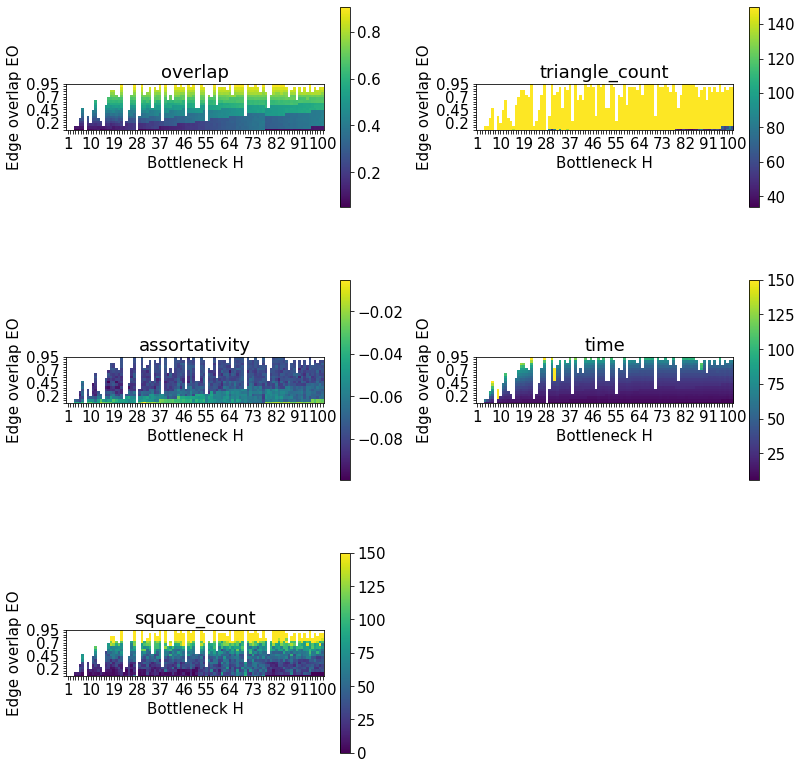

In [40]:
make_H_EO_grid_heatplot(dict_of_dicts_of_statistics=dict_of_dicts_of_statistics,
                        Hs=Hs,
                        EOs=np.around(EOs, decimals=2),
                        keys=['overlap',
                              'triangle_count', 
                              'assortativity',                            
                              'time',
                              'square_count'],
                       show_every=[9, 5])

# make_H_EO_grid_heatplot(dict_of_dicts_of_statistics=dict_of_dicts_of_statistics, Hs=Hs, EOs=EOs, keys=['time'])

#### Plot time for Hs

In [42]:
times = np.zeros((len(Hs),len(EOs)))
times.fill(None)

for key, value in dict_of_dicts_of_statistics.items():
    times[key[0], key[1]] = value['time']

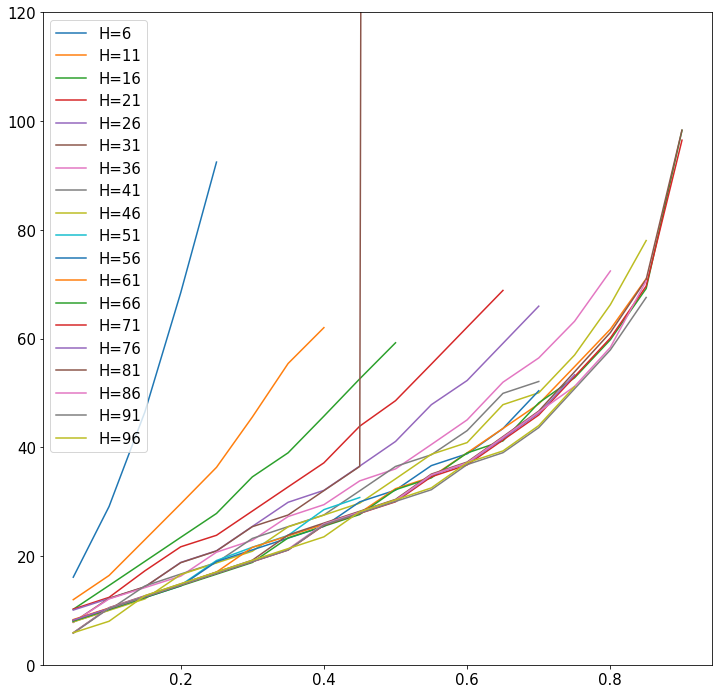

In [59]:
f, axs = plt.subplots(figsize=(12,12))

for i in range(len(Hs)):
    if i % 5 == 0:
        if not np.isnan(times[i]).all():
            axs.plot(EOs, times[i], label=f'H={Hs[i]}')

plt.ylim(0,120)            
plt.legend()
plt.show()